# Gesture Recognition - Ramraj and Prayag
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
!pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 102.8 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.3.8 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [6]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

In [9]:
project_folder='/content/drive/MyDrive/AI_MSc_Upgrad/UpgradPt2/Gesture_Project/Project_data'

##### Plotting

In [10]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [74]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

##### Sample Cropping

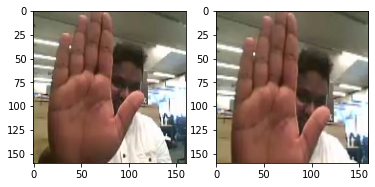

In [14]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

![image.png](attachment:image.png)

## Experimenting with Image resolution, number of frames to use and batch_size

In [ ]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [15]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.6621095314621925 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5636 - categorical_accuracy: 0.4148  
Epoch 1: saving model to model_init_2022-06-1217_27_23.560288/model-00001-1.56363-0.41478-2.35138-0.21000.h5
23/23 [==============================] - 3770s 171s/step - loss: 1.5636 - categorical_accuracy: 0.4148 - val_loss: 2.3514 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/3
22/23 [===========================>..] - ETA: 2s - loss: 0.9893 - categorical_accuracy: 0.6167
Epoch 2: saving model to model_init_2022-06-1217_27_23.560288/model-00002-0.99280-0.61538-4.91877-0.22000.h5
23/23 [==============================] - 58s 3s/step - loss: 0.9928 - categorical_accuracy: 0.6154 - val_loss: 4.9188 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 1.0514 - categorical_accuracy: 0.5867
Epoch 3: saving model to model_init_2022-06-1217_27_23.560288/model-00003-1.05142-0.58673-7.46228-0.24000.h

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6886 - categorical_accuracy: 0.3846  
Epoch 1: saving model to model_init_2022-06-1218_34_48.469064/model-00001-1.68861-0.38462-2.09886-0.16000.h5
23/23 [==============================] - 3362s 153s/step - loss: 1.6886 - categorical_accuracy: 0.3846 - val_loss: 2.0989 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.1627 - categorical_accuracy: 0.5400
Epoch 2: saving model to model_init_2022-06-1218_34_48.469064/model-00002-1.16269-0.53997-3.11898-0.19000.h5
23/23 [==============================] - 97s 4s/step - loss: 1.1627 - categorical_accuracy: 0.5400 - val_loss: 3.1190 - val_categorical_accuracy: 0.1900 - lr: 0.0010


In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
11/12 [==========================>...] - ETA: 7s - loss: 1.8299 - categorical_accuracy: 0.3697 
Epoch 1: saving model to model_init_2022-06-1219_34_41.895168/model-00001-1.82287-0.37255-1.92142-0.16000.h5
12/12 [==============================] - 101s 9s/step - loss: 1.8229 - categorical_accuracy: 0.3725 - val_loss: 1.9214 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.1676 - categorical_accuracy: 0.5430
Epoch 2: saving model to model_init_2022-06-1219_34_41.895168/model-00002-1.16764-0.54299-3.35970-0.11000.h5
12/12 [==============================] - 95s 9s/step - loss: 1.1676 - categorical_accuracy: 0.5430 - val_loss: 3.3597 - val_categorical_accuracy: 0.1100 - lr: 0.0010


In [19]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.6264 - categorical_accuracy: 0.4057
Epoch 1: saving model to model_init_2022-06-1219_38_05.255254/model-00001-1.62641-0.40573-1.58739-0.21000.h5
12/12 [==============================] - 54s 5s/step - loss: 1.6264 - categorical_accuracy: 0.4057 - val_loss: 1.5874 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.0847 - categorical_accuracy: 0.5958
Epoch 2: saving model to model_init_2022-06-1219_38_05.255254/model-00002-1.08469-0.59578-2.77896-0.13000.h5
12/12 [==============================] - 51s 5s/step - loss: 1.0847 - categorical_accuracy: 0.5958 - val_loss: 2.7790 - val_categorical_accuracy: 0.1300 - lr: 0.0010


In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.8533 - categorical_accuracy: 0.3333
Epoch 1: saving model to model_init_2022-06-1219_39_54.702330/model-00001-1.85331-0.33333-1.63755-0.16000.h5
9/9 [==============================] - 56s 7s/step - loss: 1.8533 - categorical_accuracy: 0.3333 - val_loss: 1.6375 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 1.2736 - categorical_accuracy: 0.4977
Epoch 2: saving model to model_init_2022-06-1219_39_54.702330/model-00002-1.27356-0.49774-2.30425-0.18000.h5
9/9 [==============================] - 49s 6s/step - loss: 1.2736 - categorical_accuracy: 0.4977 - val_loss: 2.3043 - val_categorical_accuracy: 0.1800 - lr: 0.0010


In [21]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5794 - categorical_accuracy: 0.3967
Epoch 1: saving model to model_init_2022-06-1219_41_44.867418/model-00001-1.57942-0.39668-6.07504-0.16000.h5
45/45 [==============================] - 106s 2s/step - loss: 1.5794 - categorical_accuracy: 0.3967 - val_loss: 6.0750 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0657 - categorical_accuracy: 0.5867
Epoch 2: saving model to model_init_2022-06-1219_41_44.867418/model-00002-1.06572-0.58673-11.00943-0.17000.h5
45/45 [==============================] - 104s 2s/step - loss: 1.0657 - categorical_accuracy: 0.5867 - val_loss: 11.0094 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6035 - categorical_accuracy: 0.4148
Epoch 1: saving model to model_init_2022-06-1219_45_16.927864/model-00001-1.60348-0.41478-6.03176-0.16000.h5
45/45 [==============================] - 59s 1s/step - loss: 1.6035 - categorical_accuracy: 0.4148 - val_loss: 6.0318 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0939 - categorical_accuracy: 0.5943
Epoch 2: saving model to model_init_2022-06-1219_45_16.927864/model-00002-1.09387-0.59427-13.13785-0.14000.h5
45/45 [==============================] - 56s 1s/step - loss: 1.0939 - categorical_accuracy: 0.5943 - val_loss: 13.1378 - val_categorical_accuracy: 0.1400 - lr: 0.0010


In [23]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6142 - categorical_accuracy: 0.4103
Epoch 1: saving model to model_init_2022-06-1219_47_13.291433/model-00001-1.61420-0.41026-3.37413-0.16000.h5
45/45 [==============================] - 53s 1s/step - loss: 1.6142 - categorical_accuracy: 0.4103 - val_loss: 3.3741 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.2368 - categorical_accuracy: 0.5189
Epoch 2: saving model to model_init_2022-06-1219_47_13.291433/model-00002-1.23684-0.51885-5.48964-0.15000.h5
45/45 [==============================] - 52s 1s/step - loss: 1.2368 - categorical_accuracy: 0.5189 - val_loss: 5.4896 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6773 - categorical_accuracy: 0.3786
Epoch 1: saving model to model_init_2022-06-1219_49_37.300034/model-00001-1.67735-0.37858-2.94861-0.18000.h5
67/67 [==============================] - 53s 784ms/step - loss: 1.6773 - categorical_accuracy: 0.3786 - val_loss: 2.9486 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1768 - categorical_accuracy: 0.5339
Epoch 2: saving model to model_init_2022-06-1219_49_37.300034/model-00002-1.17678-0.53394-5.31357-0.21000.h5
67/67 [==============================] - 52s 794ms/step - loss: 1.1768 - categorical_accuracy: 0.5339 - val_loss: 5.3136 - val_categorical_accuracy: 0.2100 - lr: 0.0010


In [25]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6644 - categorical_accuracy: 0.3952
Epoch 1: saving model to model_init_2022-06-1219_51_23.608634/model-00001-1.66444-0.39517-3.65967-0.24000.h5
67/67 [==============================] - 97s 1s/step - loss: 1.6644 - categorical_accuracy: 0.3952 - val_loss: 3.6597 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2483 - categorical_accuracy: 0.5294
Epoch 2: saving model to model_init_2022-06-1219_51_23.608634/model-00002-1.24833-0.52941-5.52468-0.15000.h5
67/67 [==============================] - 96s 1s/step - loss: 1.2483 - categorical_accuracy: 0.5294 - val_loss: 5.5247 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6553 - categorical_accuracy: 0.4012
Epoch 1: saving model to model_init_2022-06-1219_54_38.200986/model-00001-1.65527-0.40121-2.72411-0.23000.h5
67/67 [==============================] - 107s 2s/step - loss: 1.6553 - categorical_accuracy: 0.4012 - val_loss: 2.7241 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1635 - categorical_accuracy: 0.5204
Epoch 2: saving model to model_init_2022-06-1219_54_38.200986/model-00002-1.16350-0.52036-3.51705-0.16000.h5
67/67 [==============================] - 105s 2s/step - loss: 1.1635 - categorical_accuracy: 0.5204 - val_loss: 3.5171 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [27]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.7206 - categorical_accuracy: 0.3876
Epoch 1: saving model to model_init_2022-06-1219_59_02.840886/model-00001-1.72055-0.38763-10.38389-0.16000.h5
67/67 [==============================] - 58s 861ms/step - loss: 1.7206 - categorical_accuracy: 0.3876 - val_loss: 10.3839 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.3235 - categorical_accuracy: 0.4917
Epoch 2: saving model to model_init_2022-06-1219_59_02.840886/model-00002-1.32352-0.49170-9.97112-0.15000.h5
67/67 [==============================] - 58s 875ms/step - loss: 1.3235 - categorical_accuracy: 0.4917 - val_loss: 9.9711 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [28]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.6017 - categorical_accuracy: 0.3891
Epoch 1: saving model to model_init_2022-06-1220_00_59.681034/model-00001-1.60168-0.38914-1.95502-0.21000.h5
17/17 [==============================] - 61s 4s/step - loss: 1.6017 - categorical_accuracy: 0.3891 - val_loss: 1.9550 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 1.0549 - categorical_accuracy: 0.6048
Epoch 2: saving model to model_init_2022-06-1220_00_59.681034/model-00002-1.05492-0.60483-4.17068-0.22000.h5
17/17 [==============================] - 58s 4s/step - loss: 1.0549 - categorical_accuracy: 0.6048 - val_loss: 4.1707 - val_categorical_accuracy: 0.2200 - lr: 0.0010


##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [29]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_84 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_57 (Activation)  (None, 10, 80, 80, 32)  

In [31]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5822 - categorical_accuracy: 0.3952
Epoch 1: saving model to model_init_2022-06-1220_03_02.606018/model-00001-1.58222-0.39517-1.50747-0.38000.h5
17/17 [==============================] - 77s 5s/step - loss: 1.5822 - categorical_accuracy: 0.3952 - val_loss: 1.5075 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0275 - categorical_accuracy: 0.6109
Epoch 2: saving model to model_init_2022-06-1220_03_02.606018/model-00002-1.02753-0.61086-2.85073-0.18000.h5
17/17 [==============================] - 74s 5s/step - loss: 1.0275 - categorical_accuracy: 0.6109 - val_loss: 2.8507 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.7796 - categorical_accuracy: 0.6998
Epoch 3: saving model to model_init_2022-06-1220_03_02.606018/model-00003-0.77964-0.69985-2.67234-0.17000.h5
1

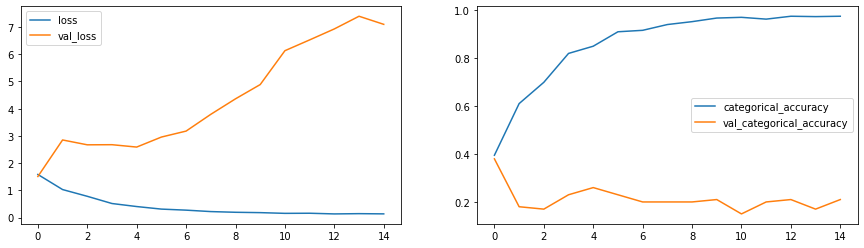

In [32]:
plot(history_model1)

##### Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [33]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_90 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_61 (Activation)  (None, 10, 80, 80, 32)  

In [34]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.1182 - categorical_accuracy: 0.3560
Epoch 1: saving model to model_init_2022-06-1220_21_01.843486/model-00001-2.11819-0.35596-1.77627-0.24000.h5
34/34 [==============================] - 121s 4s/step - loss: 2.1182 - categorical_accuracy: 0.3560 - val_loss: 1.7763 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5899 - categorical_accuracy: 0.4517
Epoch 2: saving model to model_init_2022-06-1220_21_01.843486/model-00002-1.58986-0.45173-3.05867-0.23000.h5
34/34 [==============================] - 119s 4s/step - loss: 1.5899 - categorical_accuracy: 0.4517 - val_loss: 3.0587 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3003 - categorical_accuracy: 0.5264
Epoch 3: saving model to model_init_2022-06-1220_21_01.843486/model-00003-1.30027-0.52640-2.65350-0.23000.h5

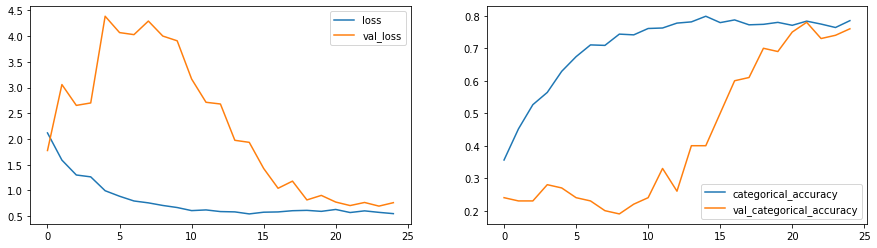

In [35]:
plot(history_model2)

##### Model is not overfitting and we get a best validation accuracy of 85% and training accuracy of 91%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x  120

In [36]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_64 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_96 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_65 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_65 (Activation)  (None, 8, 60, 60, 32)   

In [38]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.1769 - categorical_accuracy: 0.3205
Epoch 1: saving model to model_init_2022-06-1221_10_20.317328/model-00001-2.17686-0.32051-1.66105-0.16000.h5
23/23 [==============================] - 90s 4s/step - loss: 2.1769 - categorical_accuracy: 0.3205 - val_loss: 1.6610 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
22/23 [===========================>..] - ETA: 3s - loss: 1.4516 - categorical_accuracy: 0.4924
Epoch 2: saving model to model_init_2022-06-1221_10_20.317328/model-00002-1.45279-0.49170-2.55792-0.12000.h5
23/23 [==============================] - 87s 4s/step - loss: 1.4528 - categorical_accuracy: 0.4917 - val_loss: 2.5579 - val_categorical_accuracy: 0.1200 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.3826 - categorical_accuracy: 0.5294
Epoch 3: saving model to model_init_2022-06-1221_10_20.317328/model-00003-1.38257-0.52941-3.59169-0.19

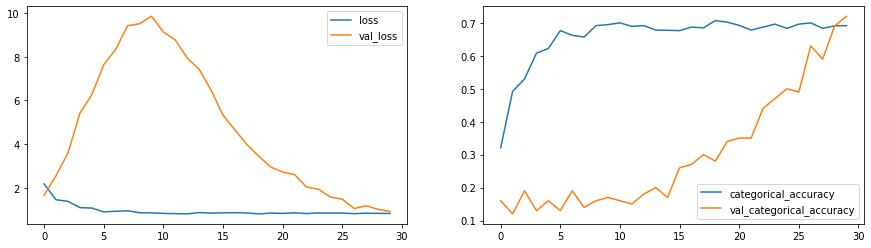

In [39]:
plot(history_model3)

##### Model has a  best validation accuracy of 84% and training accuracy of 84% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# Model 4 - Adding more layers

In [40]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_102 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_69 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_69 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_103 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [42]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9629 - categorical_accuracy: 0.3477
Epoch 1: saving model to model_init_2022-06-1221_53_56.581979/model-00001-1.96290-0.34766-2.29910-0.21000.h5
34/34 [==============================] - 90s 3s/step - loss: 1.9629 - categorical_accuracy: 0.3477 - val_loss: 2.2991 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5525 - categorical_accuracy: 0.4646
Epoch 2: saving model to model_init_2022-06-1221_53_56.581979/model-00002-1.55252-0.46456-3.80209-0.18000.h5
34/34 [==============================] - 89s 3s/step - loss: 1.5525 - categorical_accuracy: 0.4646 - val_loss: 3.8021 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.5078 - categorical_accuracy: 0.4759
Epoch 3: saving model to model_init_2022-06-1221_53_56.581979/model-00003-1.50778-0.47587-2.99604-0.21000.h5
3

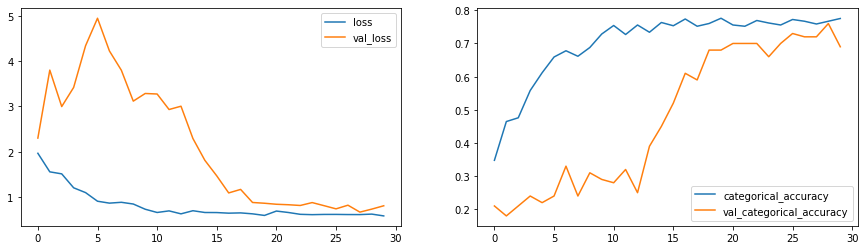

In [43]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [44]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [45]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_76 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_112 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_77 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_77 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_113 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [46]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.7993 - categorical_accuracy: 0.3741
Epoch 1: saving model to model_init_2022-06-1222_37_51.587336/model-00001-1.79928-0.37406-1.59534-0.29000.h5
34/34 [==============================] - 90s 3s/step - loss: 1.7993 - categorical_accuracy: 0.3741 - val_loss: 1.5953 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.2668 - categorical_accuracy: 0.5151
Epoch 2: saving model to model_init_2022-06-1222_37_51.587336/model-00002-1.26684-0.51508-2.22486-0.18000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.2668 - categorical_accuracy: 0.5151 - val_loss: 2.2249 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.1116 - categorical_accuracy: 0.5905
Epoch 3: saving model to model_init_2022-06-1222_37_51.587336/model-00003-1.11165-0.59050-2.01661-0.25000.h5
3

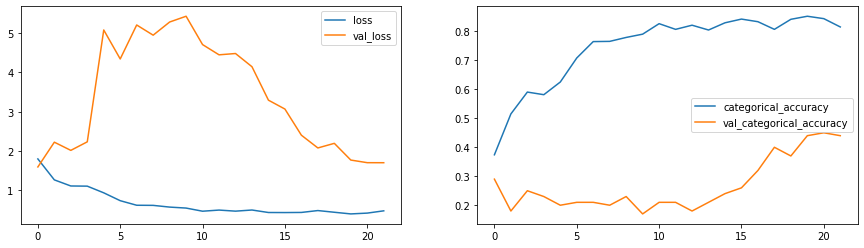

In [47]:
plot(history_model5)

##### Adding dropouts has further reduced validation accuracy as its not to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [48]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [49]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_84 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_84 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_122 (Ba  (None, 16, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_76 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_85 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_85 (Activation)  (None, 8, 50, 50, 32)   

In [50]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8611 - categorical_accuracy: 0.3145
Epoch 1: saving model to model_init_2022-06-1223_09_55.858390/model-00001-1.86111-0.31448-1.87800-0.16000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.8611 - categorical_accuracy: 0.3145 - val_loss: 1.8780 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2840 - categorical_accuracy: 0.5053
Epoch 2: saving model to model_init_2022-06-1223_09_55.858390/model-00002-1.28397-0.50528-2.93803-0.13000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.2840 - categorical_accuracy: 0.5053 - val_loss: 2.9380 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.0583 - categorical_accuracy: 0.5732
Epoch 3: saving model to model_init_2022-06-1223_09_55.858390/model-00003-1.05827-0.57315-3.28884-0.170

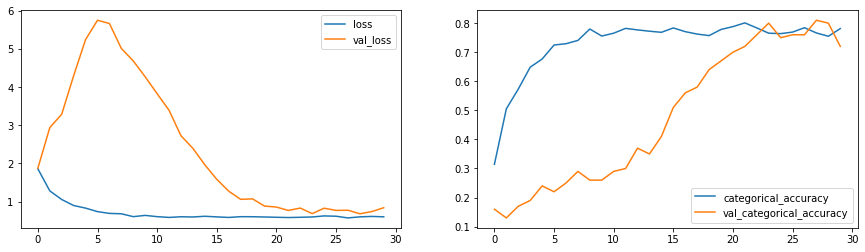

In [51]:
plot(history_model6)

###### For the above low memory foot print model the best validation accuracy of 77%

# Model 7 - reducing the number of parameters

In [52]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [53]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_88 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_88 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_128 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_80 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_89 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_89 (Activation)  (None, 8, 60, 60, 32)   

In [54]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8194 - categorical_accuracy: 0.3590
Epoch 1: saving model to model_init_2022-06-1223_51_47.340858/model-00001-1.81937-0.35897-2.06039-0.16000.h5
34/34 [==============================] - 89s 3s/step - loss: 1.8194 - categorical_accuracy: 0.3590 - val_loss: 2.0604 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2211 - categorical_accuracy: 0.5332
Epoch 2: saving model to model_init_2022-06-1223_51_47.340858/model-00002-1.22107-0.53318-2.99635-0.17000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.2211 - categorical_accuracy: 0.5332 - val_loss: 2.9964 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9969 - categorical_accuracy: 0.6282
Epoch 3: saving model to model_init_2022-06-1223_51_47.340858/model-00003-0.99690-0.62821-3.68644-0.230

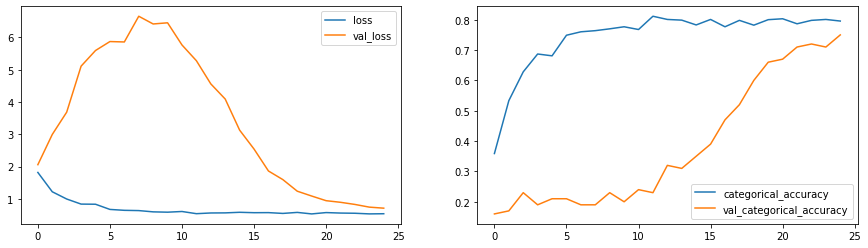

In [55]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 77%

# Model 8 - reducing the number of parameters

In [56]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [57]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_92 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_92 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_134 (Ba  (None, 16, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_84 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_93 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_93 (Activation)  (None, 8, 60, 60, 16)   

In [58]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9801 - categorical_accuracy: 0.2964
Epoch 1: saving model to model_init_2022-06-1300_28_00.931193/model-00001-1.98007-0.29638-1.62456-0.23000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.9801 - categorical_accuracy: 0.2964 - val_loss: 1.6246 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4600 - categorical_accuracy: 0.4465
Epoch 2: saving model to model_init_2022-06-1300_28_00.931193/model-00002-1.45998-0.44646-2.02016-0.13000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.4600 - categorical_accuracy: 0.4465 - val_loss: 2.0202 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2418 - categorical_accuracy: 0.5196
Epoch 3: saving model to model_init_2022-06-1300_28_00.931193/model-00003-1.24185-0.51961-2.25124-0.210

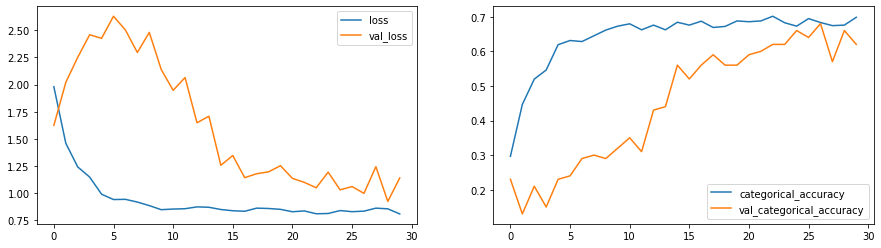

In [59]:
plot(history_model8)

###### For the above low memory foot print model the best validation accuracy of 78%

# Model 9 - CNN- LSTM Model

In [60]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [61]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32) 

In [62]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4429 - categorical_accuracy: 0.3544
Epoch 1: saving model to model_init_2022-06-1301_11_11.228644/model-00001-1.44289-0.35445-1.66804-0.21000.h5
34/34 [==============================] - 112s 3s/step - loss: 1.4429 - categorical_accuracy: 0.3544 - val_loss: 1.6680 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1584 - categorical_accuracy: 0.5317
Epoch 2: saving model to model_init_2022-06-1301_11_11.228644/model-00002-1.15843-0.53167-1.98858-0.17000.h5
34/34 [==============================] - 107s 3s/step - loss: 1.1584 - categorical_accuracy: 0.5317 - val_loss: 1.9886 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
 9/34 [======>.......................] - ETA: 1:02 - loss: 0.9408 - categorical_accuracy: 0.6444

KeyboardInterrupt: ignored

In [ ]:
plot(history_model9)

##### For CNN - LSTM model we get a best validation accuracy of 75%

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# More Augmentation

In [65]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [ ]:
#class Test(ModelBuilderMoreAugmentation):
#    def define_model(self):
#        pass

#test_generator=Test()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,29,:,:,:])   
#axes[1].imshow(batch_data[3,29,:,:,:])   

# Model 10 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [75]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

In [ ]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

In [ ]:
plot(history_model10)

# Model 11 - (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [ ]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

In [ ]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

In [ ]:
plot(history_model11)

# Model 12 - Adding more layers - Similar to model 4

In [ ]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

In [ ]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

In [ ]:
plot(history_model12)

# Model 13 - Adding dropouts - Similar to Model 5

In [ ]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

In [ ]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

In [ ]:
plot(history_model13)

# Model 14 - reducing network parameters - Similar to Model 6

In [ ]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

In [ ]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

In [ ]:
plot(history_model14)

# Model 15 - reducing network parameters - Similar to model 7

In [ ]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

In [ ]:
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

In [ ]:
plot(history_model15)

# Model 16 - reducing network parameters - Similar to Model 8

In [ ]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

In [ ]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

In [ ]:
plot(history_model16)

# Model 17 - CNN LSTM with GRU - Similar to Model 9

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

In [ ]:
plot(history_model17)

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

# Model 18 - Transfer Learning

In [ ]:
from keras.applications import mobilenet

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

In [ ]:
plot(history_model18)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

# Model 19 - Transfer Learning with GRU and training all weights

In [66]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [67]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)             

In [68]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1609 - categorical_accuracy: 0.5264
Epoch 1: saving model to model_init_2022-06-1301_16_51.964097/model-00001-1.16092-0.52640-0.55051-0.75000.h5
133/133 [==============================] - 103s 745ms/step - loss: 1.1609 - categorical_accuracy: 0.5264 - val_loss: 0.5505 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6806 - categorical_accuracy: 0.7511
Epoch 2: saving model to model_init_2022-06-1301_16_51.964097/model-00002-0.68058-0.75113-0.60160-0.75000.h5
133/133 [==============================] - 92s 696ms/step - loss: 0.6806 - categorical_accuracy: 0.7511 - val_loss: 0.6016 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5169 - categorical_accuracy: 0.8039
Epoch 3: saving model to model_init_2022-06-1301_16_51.964097/model-00003-0.51691-0.80392-0.4

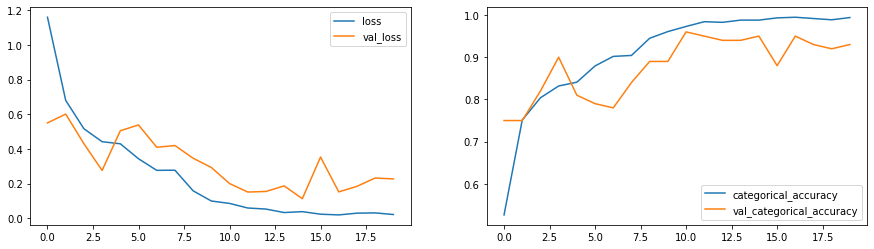

In [69]:
plot(history_model19)

# Consolidated Final Models

![image.png](attachment:image.png)

# Loading model and Testing

In [72]:
import time
from keras.models import load_model
model = load_model('/content/model_init_2022-06-1301_16_51.964097/model-00020-0.02125-0.99397-0.22684-0.93000.h5')

In [80]:
test_generator=ModelConv3D10()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=3)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [81]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [82]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[1 1 3 4 1]
